## VISUALIZING SALIENCY

This a notebook to test how does the package keras-vis performs and to check wether it is helpfull.


In [1]:
!nvidia-smi | grep "Tesla"

|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |


In [2]:
!pip install --upgrade tf-keras-vis tensorflow matplotlib

Requirement already up-to-date: tf-keras-vis in /usr/local/lib/python3.7/dist-packages (0.7.0)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)


In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


We will load a VGG16 model to test this package.

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

As we can see inputs for model are in 224x224 so a sub/ super sampling will be needed.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Before and after: 
183 275 224 224 183 275 224 224


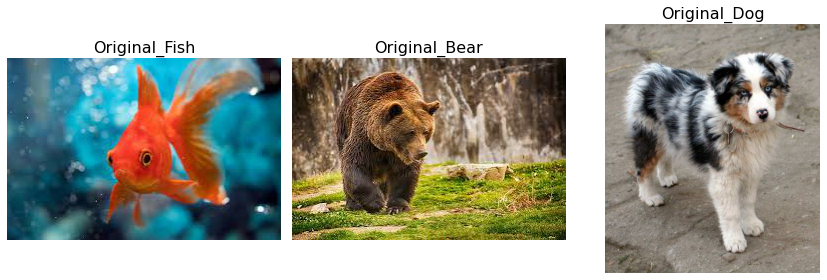

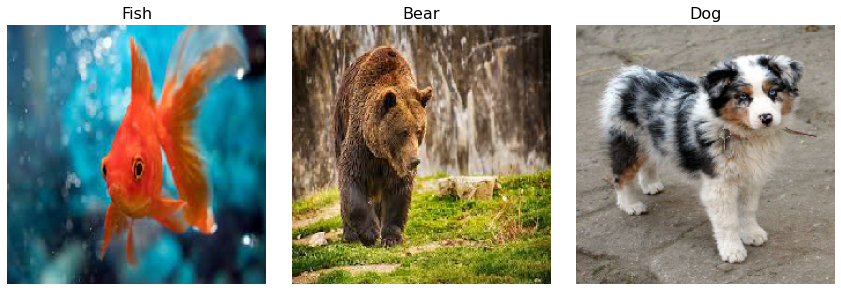

In [14]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['Fish', 'Bear', 'Dog']

# Load images and Convert them to a Numpy array
img1 = load_img('images/fish.jpg', target_size=(224, 224))
img2 = load_img('images/bear.jpg', target_size=(224, 224))
img3 = load_img('images/dog.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

img11, img22, img33 = load_img('images/fish.jpg'), load_img('images/bear.jpg') , load_img('images/dog.jpg')
images_original = np.asarray([np.array(img11), np.array(img22), np.array(img33)])

print("Before and after: ")
print(img11.height, img11.width, img1.height, img1.width, img22.height, img22.width, img2.height, img2.width)

# Preparing input data for VGG16
X = preprocess_input(images)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(['Original_'+ title for title in image_titles]):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images_original[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()



## Model modifier

When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function. Here, we create and use ReplaceToLinear instance.
I do not understand well this part yet. Let us see if I find the explanation later. To better understand its effect I will change the function a bit with the possibility to introduce the layer to be studied as a parameter and leaving the last one by default.

In [25]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using ReplaceToLinear instance,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model, layer: int = -1):
    cloned_model.layers[layer].activation = tf.keras.activations.linear

In [16]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([1, 294, 413])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][294], output[2][413])

## Vanilla Saliency
Saliency generates a saliency map that appears the regions of ​​the input image that contributes the most to the output value.


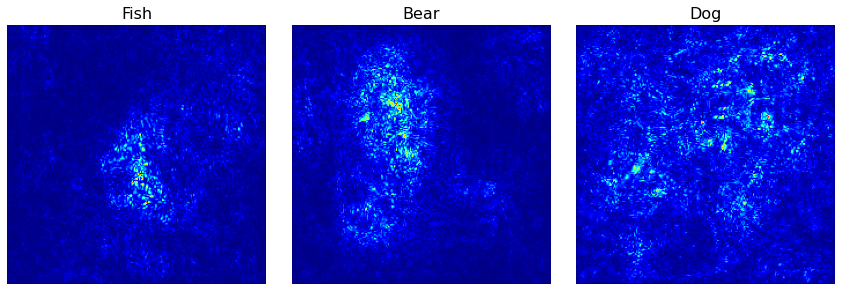

CPU times: user 901 ms, sys: 103 ms, total: 1 s
Wall time: 924 ms


In [47]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In order to understand if there are differences between layers let us study what layers does VGG16 own. On previous notebooks I show that with a higher number of filters the net learns little details
and on the contrary it learns bigger features.


I have figured out that we are always showing the last layer results, since we are changing just an activation function but not choosing the layer to study.

In [42]:
model.layers, model.layers[1], model.layers[7]

([<tensorflow.python.keras.engine.input_layer.InputLayer at 0x7fd2beb19450>,
 <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fd2a01dbd10>)

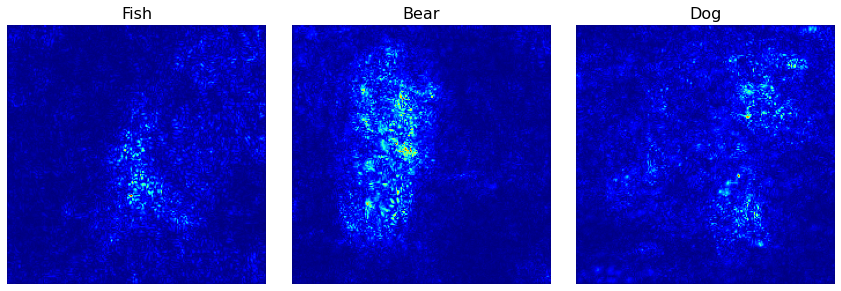

CPU times: user 593 ms, sys: 108 ms, total: 700 ms
Wall time: 591 ms


In [30]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=model_modifier_function(model, 1),
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

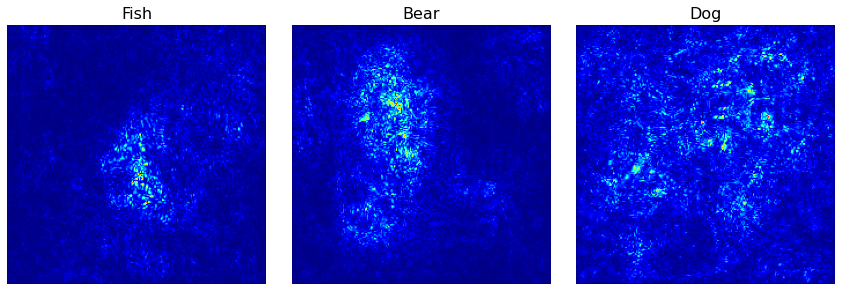

CPU times: user 448 ms, sys: 105 ms, total: 553 ms
Wall time: 437 ms


In [44]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=model_modifier_function(model, 7),
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

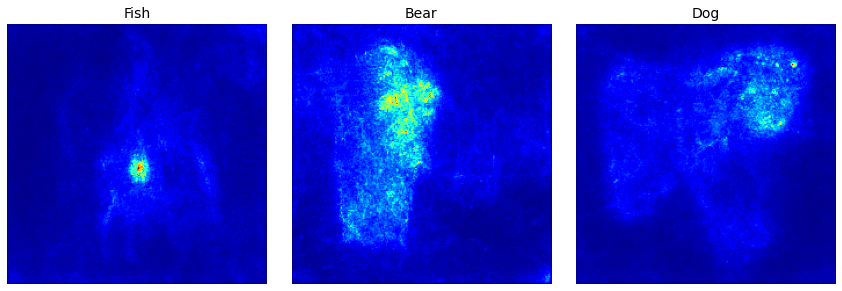

CPU times: user 1.62 s, sys: 136 ms, total: 1.76 s
Wall time: 1.9 s


In [18]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/smoothgrad.png')
plt.show()

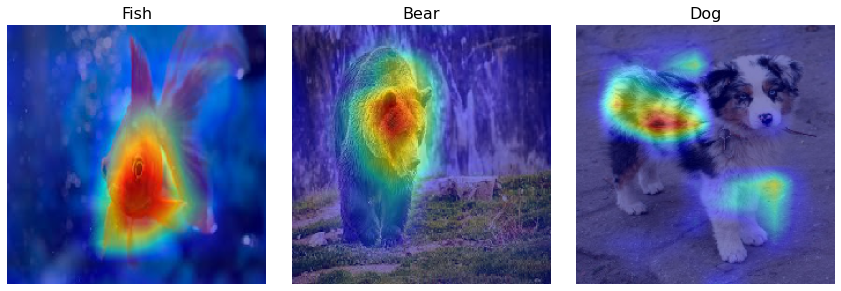

CPU times: user 1.02 s, sys: 246 ms, total: 1.27 s
Wall time: 1.15 s


In [19]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

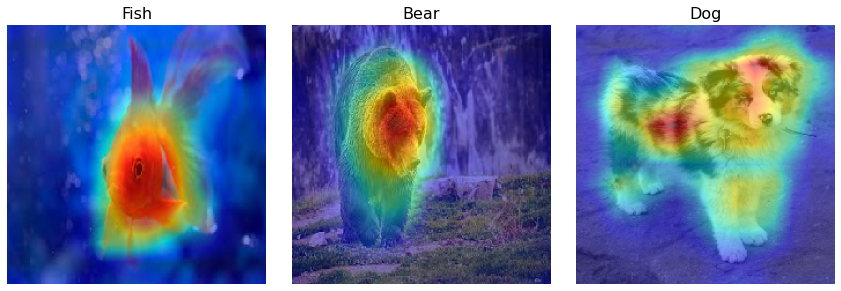

CPU times: user 1.37 s, sys: 145 ms, total: 1.52 s
Wall time: 1.41 s


In [20]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/gradcam_plus_plus.png')
plt.show()

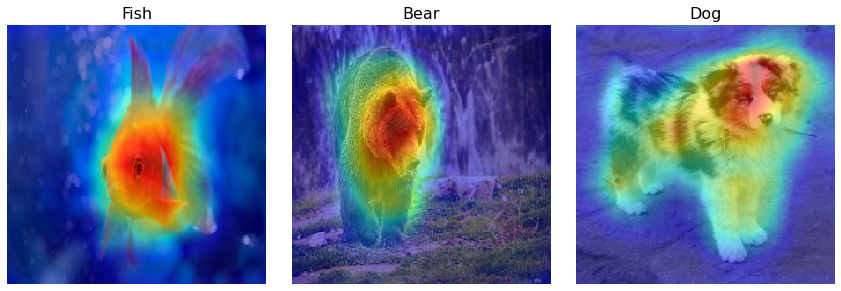

CPU times: user 23.9 s, sys: 740 ms, total: 24.7 s
Wall time: 24.2 s


In [21]:
%%time

from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [23]:
CategoricalScore.

SyntaxError: ignored